---

_You are currently looking at **version 1.0** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the Jupyter Notebook FAQ course resource._

---

# Assignment 4 - Predicting and understanding viewer engagement with educational videos 

With the accelerating popularity of online educational experiences, the role of online lectures and other educational video continues to increase in scope and importance. Open access educational repositories such as <a href="http://videolectures.net/">videolectures.net</a>, as well as Massive Open Online Courses (MOOCs) on platforms like Coursera, have made access to many thousands of lectures and tutorials an accessible option for millions of people around the world. Yet this impressive volume of content has also led to a challenge in how to find, filter, and match these videos with learners. This assignment gives you an example of how machine learning can be used to address part of that challenge.

## About the prediction problem

One critical property of a video is engagement: how interesting or "engaging" it is for viewers, so that they decide to keep watching. Engagement is critical for learning, whether the instruction is coming from a video or any other source. There are many ways to define engagement with video, but one common approach is to estimate it by measuring how much of the video a user watches. If the video is not interesting and does not engage a viewer, they will typically abandon it quickly, e.g. only watch 5 or 10% of the total. 

A first step towards providing the best-matching educational content is to understand which features of educational material make it engaging for learners in general. This is where predictive modeling can be applied, via supervised machine learning. For this assignment, your task is to predict how engaging an educational video is likely to be for viewers, based on a set of features extracted from the video's transcript, audio track, hosting site, and other sources.

We chose this prediction problem for several reasons:

* It combines a variety of features derived from a rich set of resources connected to the original data;
* The manageable dataset size means the dataset and supervised models for it can be easily explored on a wide variety of computing platforms;
* Predicting popularity or engagement for a media item, especially combined with understanding which features contribute to its success with viewers, is a fun problem but also a practical representative application of machine learning in a number of business and educational sectors.


## About the dataset

We extracted training and test datasets of educational video features from the VLE Dataset put together by researcher Sahan Bulathwela at University College London. 

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single educational video, and includes information about diverse properties of the video content as described further below. The target variable is `engagement` which was defined as True if the median percentage of the video watched across all viewers was at least 30%, and False otherwise.

Note: Any extra variables that may be included in the training set are simply for your interest if you want an additional source of data for visualization, or to enable unsupervised and semi-supervised approaches. However, they are not included in the test set and thus cannot be used for prediction. **Only the data already included in your Coursera directory can be used for training the model for this assignment.**

For this final assignment, you will bring together what you've learned across all four weeks of this course, by exploring different prediction models for this new dataset. In addition, we encourage you to apply what you've learned about model selection to do hyperparameter tuning using training/validation splits of the training data, to optimize the model and further increase its performance. In addition to a basic evaluation of model accuracy, we've also provided a utility function to visualize which features are most and least contributing to the overall model performance.

**File descriptions** 
    assets/train.csv - the training set (Use only this data for training your model!)
    assets/test.csv - the test set
<br>

**Data fields**

train.csv & test.csv:

    title_word_count - the number of words in the title of the video.
    
    document_entropy - a score indicating how varied the topics are covered in the video, based on the transcript. Videos with smaller entropy scores will tend to be more cohesive and more focused on a single topic.
    
    freshness - The number of days elapsed between 01/01/1970 and the lecture published date. Videos that are more recent will have higher freshness values.
    
    easiness - A text difficulty measure applied to the transcript. A lower score indicates more complex language used by the presenter.
    
    fraction_stopword_presence - A stopword is a very common word like 'the' or 'and'. This feature computes the fraction of all words that are stopwords in the video lecture transcript.
    
    speaker_speed - The average speaking rate in words per minute of the presenter in the video.
    
    silent_period_rate - The fraction of time in the lecture video that is silence (no speaking).
    
train.csv only:
    
    engagement - Target label for training. True if learners watched a substantial portion of the video (see description), or False otherwise.
    

## Evaluation

Your predictions will be given as the probability that the corresponding video will be engaging to learners.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 

Your grade will be based on the AUC score computed for your classifier. A model with an AUC (area under ROC curve) of at least 0.8 passes this assignment, and over 0.85 will receive full points.
___

For this assignment, create a function that trains a model to predict significant learner engagement with a video using `asset/train.csv`. Using this model, return a Pandas Series object of length 2309 with the data being the probability that each corresponding video from `readonly/test.csv` will be engaging (according to a model learned from the 'engagement' label in the training set), and the video index being in the `id` field.

Example:

    id
       9240    0.401958
       9241    0.105928
       9242    0.018572
                 ...
       9243    0.208567
       9244    0.818759
       9245    0.018528
             ...
       Name: engagement, dtype: float32
       
### Hints

* Make sure your code is working before submitting it to the autograder.

* Print out and check your result to see whether there is anything weird (e.g., all probabilities are the same).

* Generally the total runtime should be less than 10 mins. 

* Try to avoid global variables. If you have other functions besides engagement_model, you should move those functions inside the scope of engagement_model.

* Be sure to first check the pinned threads in Week 4's discussion forum if you run into a problem you can't figure out.

### Extensions

* If this prediction task motivates you to explore further, you can find more details here on the original VLE dataset and others related to video engagement: https://github.com/sahanbull/VLE-Dataset



In [5]:
# import necessary libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV


np.random.seed(0)   

### __Step 1: Understand the Problem__

<u>__Goal__</u>
The objective of this project is to predict **viewer engagement** with educational videos.
The target variable (**engagement**) is binary:
- **1 (True):** Engaging video  
- **0 (False):** Not engaging video  

<u>__Evaluation Metric__</u>
- The model will be evaluated using **AUC-ROC (Area Under the Receiver Operating Characteristic Curve)**.
- AUC measures how well the model ranks engaging videos higher than non-engaging ones.

In [6]:
df = pd.read_csv('assets/train.csv')
df_test = pd.read_csv('./assets/test.csv')


### __Step 2: Explore the Data (Exploratory Data Analysis - EDA)__
* Check for missing values and handle them if necessary.
* Check the distribution of the target variable ('engagement') to see if the data is imbalanced.
* Examine feature distributions and visualize them.
* Check correlations between features and the target variable.


checking for missing values
id                            0
title_word_count              0
document_entropy              0
freshness                     0
easiness                      0
fraction_stopword_presence    0
normalization_rate            0
speaker_speed                 0
silent_period_rate            0
engagement                    0
dtype: int64 
Hence no missing values
----------------------------------------------------------
----------------------------------------------------------
----------------------------------------------------------
checking distribution of target variable
engagement
0    8342
1     897
Name: count, dtype: int64
Hence this shows that the data is imbalanced
----------------------------------------------------------
----------------------------------------------------------
----------------------------------------------------------
Examine distribution of features
       title_word_count  document_entropy     freshness     easiness  \
count       

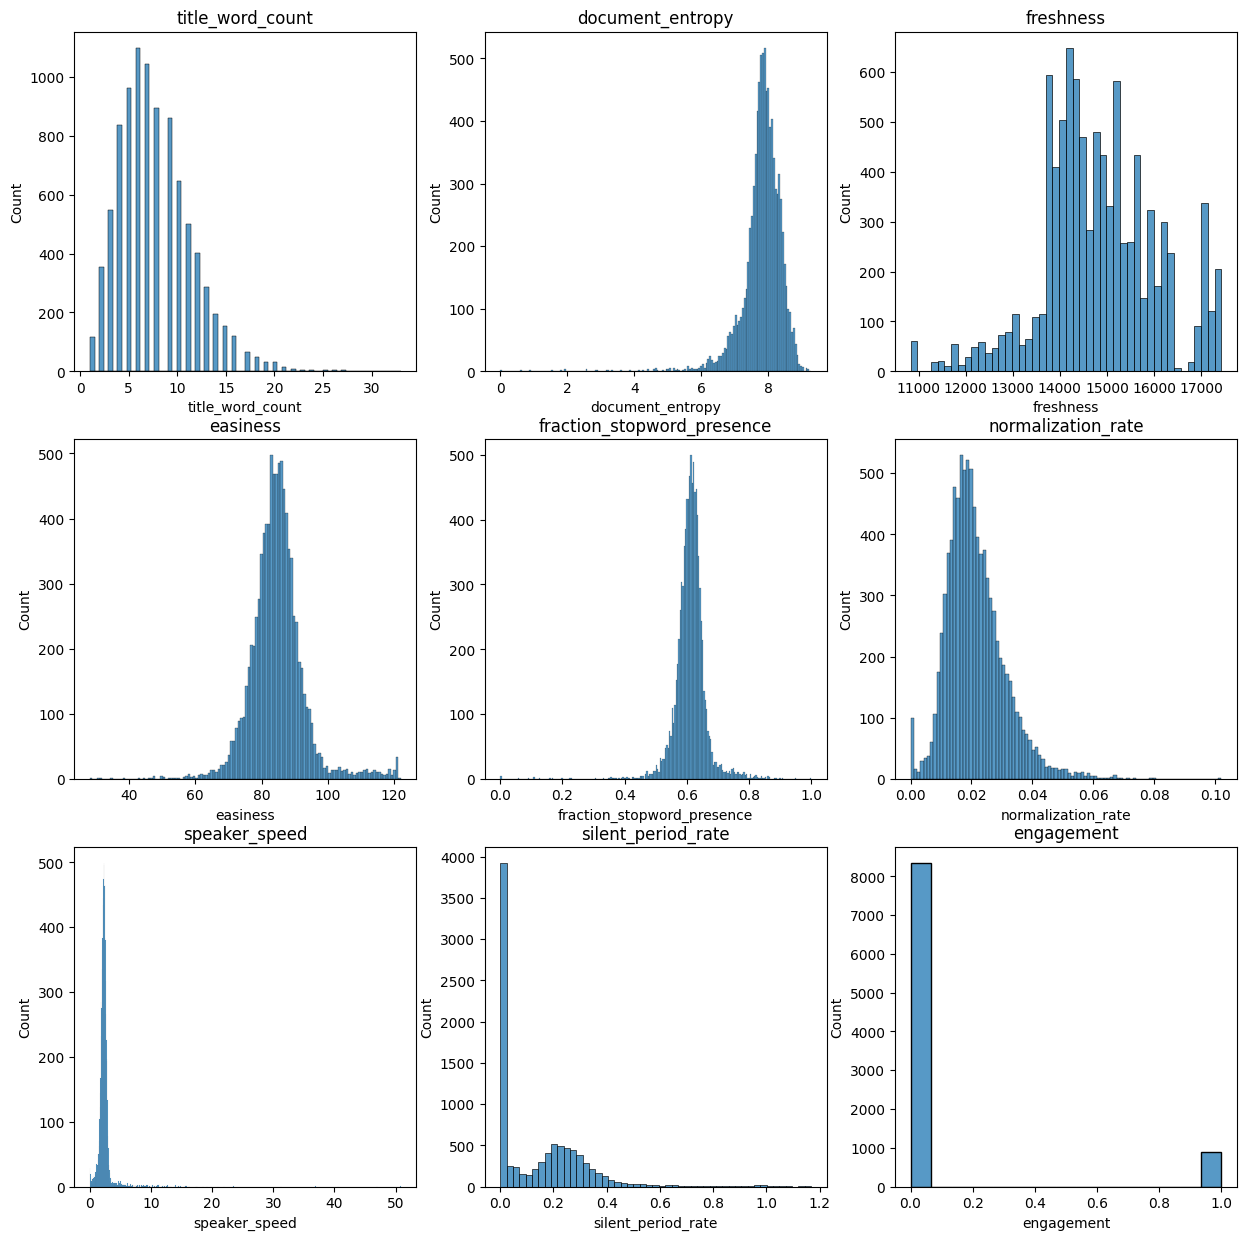

----------------------------------------------------------
----------------------------------------------------------
----------------------------------------------------------
Check correlations between features
Show correlations
                            title_word_count  document_entropy  freshness  \
title_word_count                    1.000000          0.007861   0.010169   
document_entropy                    0.007861          1.000000  -0.140501   
freshness                           0.010169         -0.140501   1.000000   
easiness                           -0.040933         -0.376209  -0.191736   
fraction_stopword_presence         -0.014945         -0.057805  -0.110930   
normalization_rate                  0.039705          0.038679   0.131065   
speaker_speed                      -0.076406          0.264153   0.016699   
silent_period_rate                 -0.007335         -0.352060  -0.414012   
engagement                         -0.030120         -0.263970   0.225711   

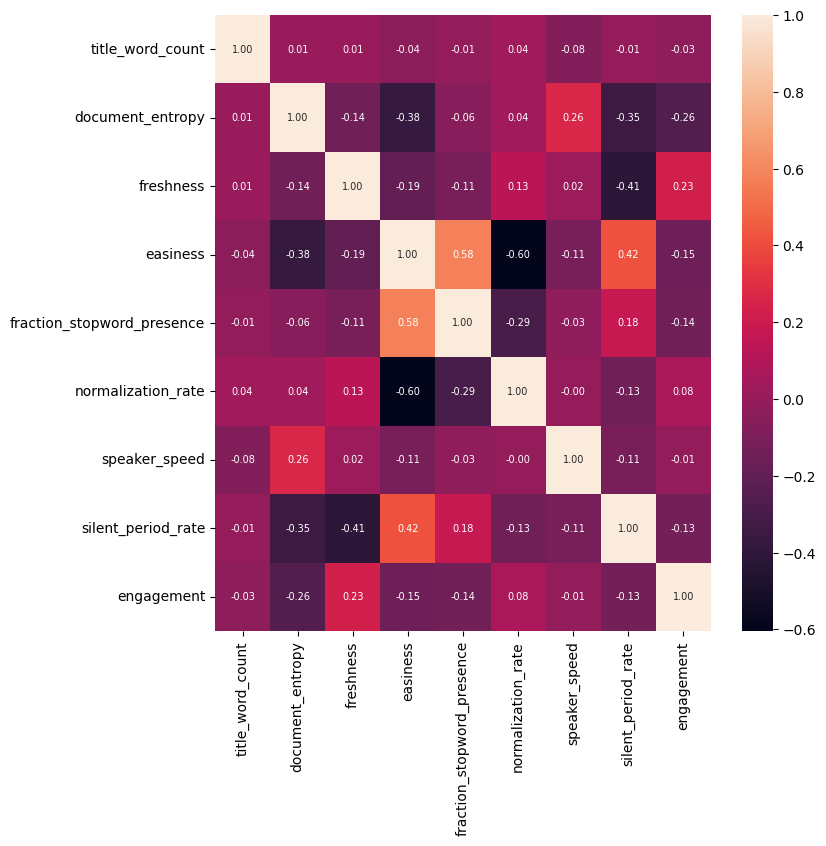

In [10]:
def EDA():
    
    # Checking for missing values
    print('checking for missing values')
    print(('{} \nHence no missing values').format(df.isnull().sum()))
    print('----------------------------------------------------------')
    print('----------------------------------------------------------')
    print('----------------------------------------------------------')
    

    # Checking distribution of target variable
    print('checking distribution of target variable')
    print('{}\nHence this shows that the data is imbalanced'.format(df['engagement'].value_counts()))
    print('----------------------------------------------------------')
    print('----------------------------------------------------------')
    print('----------------------------------------------------------')
    

    # Examining feature distributions
    print('Examine distribution of features')
    print(df.drop(columns=['id']).describe())
    print('----------------------------------------------------------')
    
    # Visualizing feature distributions
    print('Showing Feature Distribution')
    cols = len(df.columns[1:])
    fig,subaxes = plt.subplots(int(cols/3),3,figsize=(15,15))
    df['engagement'] = df['engagement'].astype(int)
    n = 1
    for row in subaxes:
        for this_axis in row:
            sns.histplot(df.iloc[:,n],ax=this_axis)
            this_axis.set_title('{}'.format(df.columns[n]))
            n = n+1
    plt.show()
    print('----------------------------------------------------------')
    print('----------------------------------------------------------')
    print('----------------------------------------------------------')
    
    
    # Checking correlation between features
    print('Check correlations between features')
    print('Show correlations')
    correlation = df.iloc[:,1:].corr()
    print(correlation )
    
    # Visualizing correlation
    print('----------------------------------------------------------')
    print('Show correlation chart')
    plt.figure(figsize= (8,8))
    sns.heatmap(correlation, cbar=True, annot=True, fmt='.2f',annot_kws={'size': 7})
    plt.show()
    
    
    return 

EDA()

### __Step 3: Preprocess the Data__
* Split and prepare data from df
* Split the training data into train and validation sets (e.g., 80%-20%) for model tuning.


In [11]:
def preprocessing():
    
    # turning category to integer
    df['engagement'] = df['engagement'].astype(int)
    
    # Spliting data into features and targets
    X = df[df.columns[1:-1]]
    y = df[df.columns[-1]]
    
    # Splitting the features and targets into training and validation sets
    X_train,X_val,y_train,y_val = train_test_split(X,y)
    
    return X_train,X_val,y_train,y_val

### __Step 4: Choose and Train Models__
Since this is a classification problem with about 10,000 entries, so we shall start with these models:
1. Logistic Regression (a good baseline)
2. Support Vector Machine
3. Random Forest (handles interactions well)
4. Gradient Boosting

In [26]:
# ROC_Curve plotting helper function
def plot_roc_curves(y_val,y_scores,model):
    fpr, tpr, _ = roc_curve(y_val, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,6))
    plt.xlim([-0.01, 1.00])
    plt.ylim([-0.01, 1.00])
    plt.plot(fpr, tpr, lw=3, label=' ROC curve (area = {:0.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('{}, ROC curve\n(Binary Classifier)'.format(model.__class__.__name__), fontsize=16)
    plt.legend(loc='lower right', fontsize=13)
    plt.show()

    return    

Different models and ROC-AUC scores
------------------------------------------------------------------------------------------------------


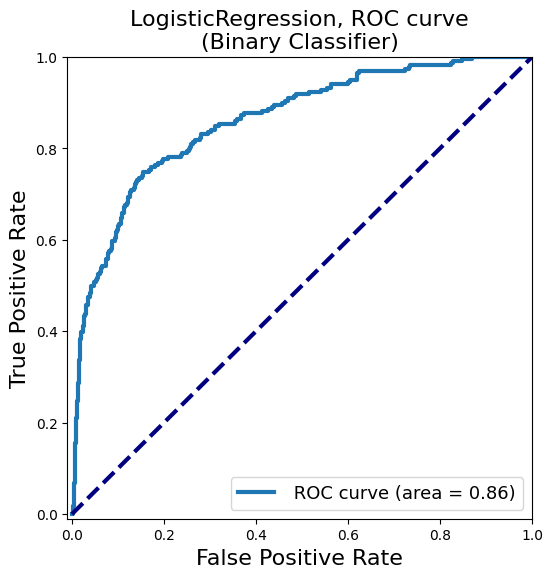

------------------------------------------------------------------------------------------------------


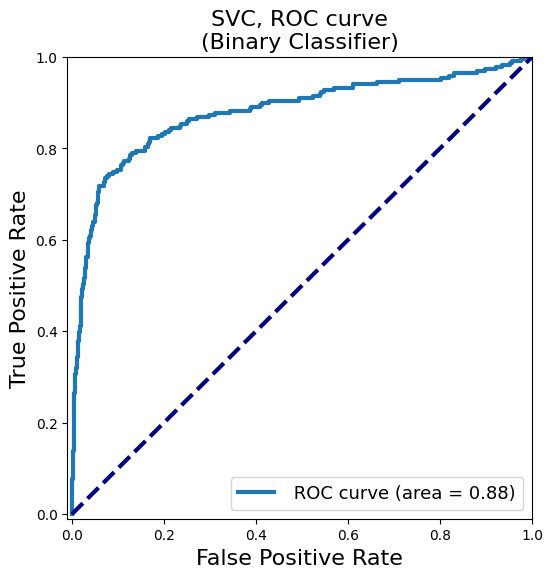

------------------------------------------------------------------------------------------------------


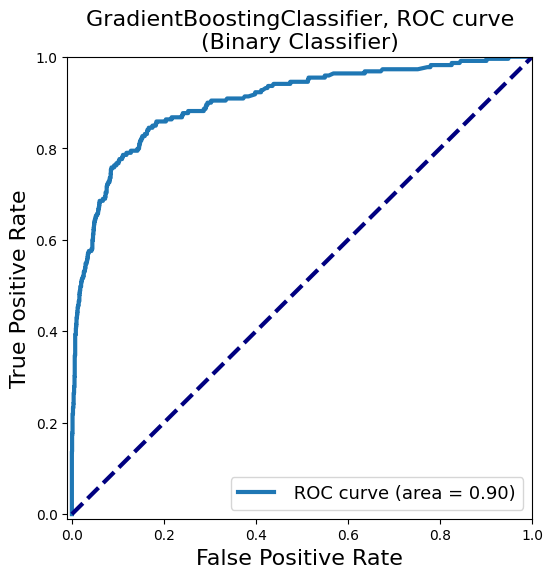

------------------------------------------------------------------------------------------------------


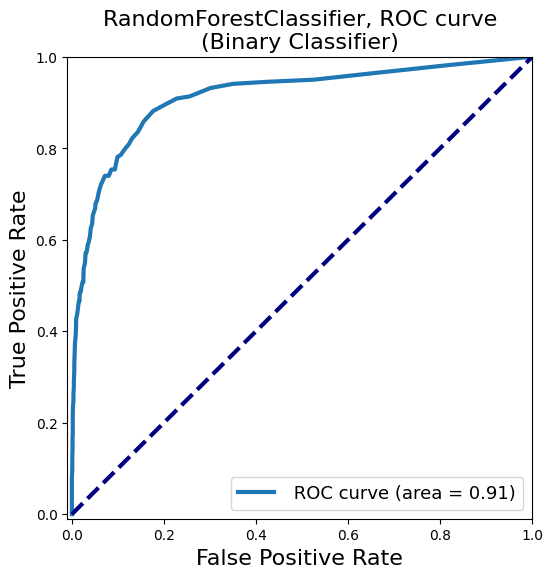

------------------------------------------------------------------------------------------------------

From the model comparison, Random Forest seems to be the best, hence let's
tune its parameters to get the best parameter values to produce the best results


In [29]:
# Actual Model choosing function
def choose_model():
    X_train,X_val,y_train,y_val = preprocessing()
    
    scaler = MinMaxScaler()
    
    # Different model options
    models = {'Normalizing models': [LogisticRegression(random_state = 0),SVC(random_state = 0)],
              'Non-normalizing models': [GradientBoostingClassifier(random_state = 0),RandomForestClassifier(random_state = 0)]}
    
    print('Different models and ROC-AUC scores')
    print('------------------------------------------------------------------------------------------------------')
    for model_name, model_list in models.items():
        for model in model_list:
            if model_name == 'Normalizing models':
                X_train_scaled = scaler.fit_transform(X_train)
                X_val_scaled = scaler.transform(X_val)
                modelling = model.fit(X_train_scaled,y_train)
                if hasattr(model,'decision_function'):
                    y_scores = modelling.decision_function(X_val_scaled)
                else:
                    y_scores = modelling.predict_proba(X_val_scaled)[:,1]
                plot_roc_curves(y_val,y_scores,model)
                print('------------------------------------------------------------------------------------------------------')   

            else:
                modelling = model.fit(X_train,y_train)
                if hasattr(model,'decision_function'):
                    y_scores = modelling.decision_function(X_val)
                else:
                    y_scores = modelling.predict_proba(X_val)[:,1]
                fpr, tpr, _ = roc_curve(y_val, y_scores)
                roc_auc = auc(fpr, tpr)
                plot_roc_curves(y_val,y_scores,model)
                print('------------------------------------------------------------------------------------------------------')   
    print('''\nFrom the model comparison, Random Forest seems to be the best, hence let's
tune its parameters to get the best parameter values to produce the best results''')

    return

choose_model()

### __Step 5: Tune Hyperparameters__
* Use GridSearchCV to find the best parameters.
* Some key parameters to tune:
    * Random Forest: n_estimators, max_depth
* Evaluate models using AUC-ROC score.

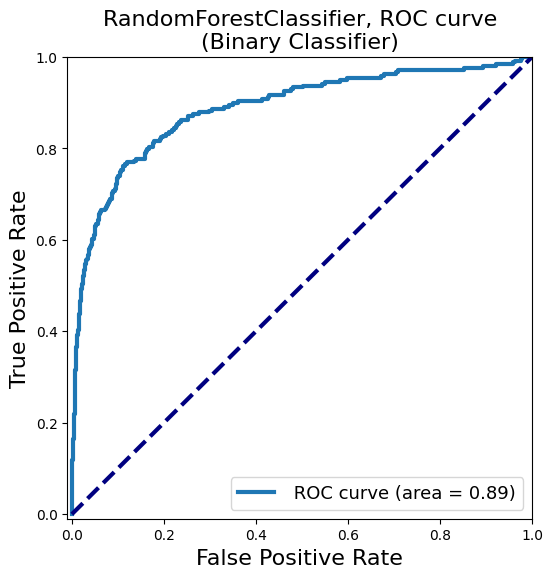

Grid best score (AUC):  0.8890566149459828
Test set AUC:  0.885765792803608
Grid best parameter (max. AUC):  {'max_depth': 10, 'n_estimators': 200}
----------------------------------------------------------
----------------------------------------------------------
----------------------------------------------------------


{'max_depth': 10, 'n_estimators': 200}

In [32]:
def tune_hyperparameters(plot=True,verbose=True):
    X_train,X_val,y_train,y_val = preprocessing()

    clf = RandomForestClassifier(random_state = 0)
    # Parameters to tune from
    grid_values = {
        'n_estimators': [10 ,50, 100, 200],
        'max_depth': [2, 5, 10, 20,]}
    
    # Optimize over grid parameters using AUC as metric
    grid_clf_auc = GridSearchCV(clf, param_grid = grid_values, scoring = 'roc_auc')
    grid_clf_auc.fit(X_train, y_train)
    if hasattr(clf,'decision_function'):
        y_scores = grid_clf_auc.decision_function(X_val) 
    else:
        y_scores = grid_clf_auc.predict_proba(X_val)[:,1]
    if plot:    
        plot_roc_curves(y_val,y_scores,clf)
    if verbose:    
        print('Grid best score (AUC): ', grid_clf_auc.best_score_)
        print('Test set AUC: ', roc_auc_score(y_val, y_scores))
        print('Grid best parameter (max. AUC): ', grid_clf_auc.best_params_)
        print('----------------------------------------------------------')
        print('----------------------------------------------------------')
        print('----------------------------------------------------------')
    
    return grid_clf_auc.best_params_ 
tune_hyperparameters()      

### __Step 6: Extracting and visualizing feature importance__
* We need to determine which features contribute the most to predicting viewer engagement with educational videos as this would help improve our model

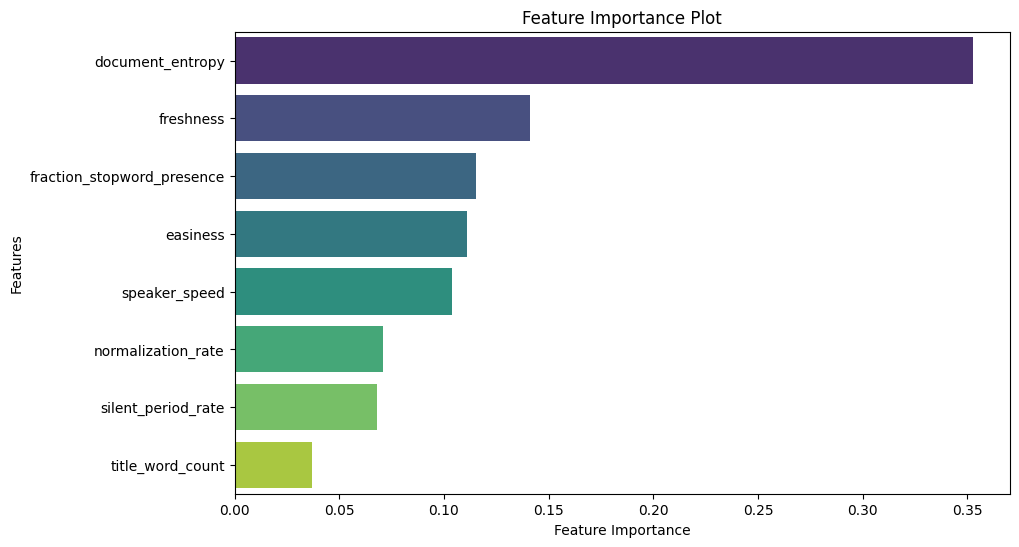

Selected Features: ['document_entropy', 'freshness', 'fraction_stopword_presence', 'easiness', 'speaker_speed', 'normalization_rate', 'silent_period_rate']


['document_entropy',
 'freshness',
 'fraction_stopword_presence',
 'easiness',
 'speaker_speed',
 'normalization_rate',
 'silent_period_rate']

In [35]:
def show_feature_importance(plot=True,verbose=True):    
    # turning category to integer
    df['engagement'] = df['engagement'].astype(int)
    
    # Spliting data into features and targets
    X = df[df.columns[1:-1]]
    y = df[df.columns[-1]]
    best_parameters = tune_hyperparameters(plot=False,verbose=False)
    model = RandomForestClassifier(random_state = 0,**best_parameters)
    model.fit(X,y)
    
    feature_importance = model.feature_importances_
    
    importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    
    if plot:
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
        plt.xlabel('Feature Importance')
        plt.ylabel('Features')
        plt.title('Feature Importance Plot')
        plt.show()
    
    # Define threshold (adjust as needed)
    threshold = 0.05

    # Get list of features to keep
    important_features = importance_df[importance_df['Importance'] >= threshold]['Feature'].tolist()
    if verbose:
        print("Selected Features:", important_features)

    
    return important_features

show_feature_importance()

### __Step 7: Make Predictions on Test Data__
* Use the best-performing model to predict engagement probabilities on test.csv.
* Ensure the predictions are in the required format (Pandas Series with the id column as index).

In [37]:
def make_prediction():
    important_features = show_feature_importance(plot=False,verbose=False) 
    
    df['engagement'] = df['engagement'].astype(int)
    
    X_train,y_train = df[important_features],df.iloc[:,-1]
    X_test = df_test[important_features]
    
    
    best_parameters = tune_hyperparameters(plot=False,verbose=False)
    
    clf = RandomForestClassifier(random_state = 0,**best_parameters).fit(X_train,y_train)
    
    y_scores = clf.predict_proba(X_test)[:,1]
    
    return y_scores

### __Step 8: Load Result__ 
* Load the result of the final model and assert the results

In [38]:
def engagement_model():
    indices = df_test['id'].values
    probabilities = make_prediction()
    record = pd.Series(probabilities,index=indices)
    return record
    
    
engagement_model()

assert isinstance(engagement_model(), pd.Series), "Your function should return a pd.Series. "
assert len(engagement_model()) == 2309, "Your series is of incorrect length: expected 2309 "
assert np.issubdtype(engagement_model().index.dtype, np.integer), "Your answer pd.Series should have an index of integer type representing video id."